In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [3]:
data = pd.read_csv("credit_risk_dataset.csv")

#### Data Information

In [4]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
data.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26
32580,66,42000,RENT,2.0,MEDICAL,B,6475,9.99,0,0.15,N,30


In [6]:
print('Shape of data :: ',data.shape)

Shape of data ::  (32581, 12)


In [7]:
print('Data Information ::')
data.info()

Data Information ::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
#### filling missing values

# filling person_emp_length with null values
data.person_emp_length.fillna(value = data.person_emp_length.mean(),inplace=True)


# filling loan_int_rate null values with mean
data.loan_int_rate.fillna(value = data.loan_int_rate.mean(),inplace=True)

In [9]:
print('Data Description :: ')
data.describe()

Data Description :: 


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.085333,6322.086646,3.081605,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,11.011695,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [10]:
data = pd.get_dummies(data)

In [11]:
labels =data.loan_status
data.drop(["loan_status"],axis=1,inplace=True)

#### Splitting data(ORIGINAL DATA)

In [12]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,stratify=labels,random_state=42)

In [14]:
### Defining a function to measure performance parameters
def scores(Y_true,Y_pred):
    accuracy = accuracy_score(Y_true,Y_pred)
    fscore = f1_score(Y_true,Y_pred)
    recall = recall_score(Y_true,Y_pred)
    precision = precision_score(Y_true,Y_pred)
    confuison = confusion_matrix(Y_true,Y_pred)
    return accuracy,recall,precision,fscore,confuison

# Models

# Original Data

## Traditional Approach

#### 1.  Logistic Regression

In [15]:
log_reg = LogisticRegression()

start = time.time()
log_reg.fit(X_train,Y_train)
logistic_trainTime = time.time() - start

logistic_predValues = log_reg.predict(X_test)
accuracy_log,recall_log,precision_log,fscore_log,confusion = scores(Y_test,logistic_predValues)

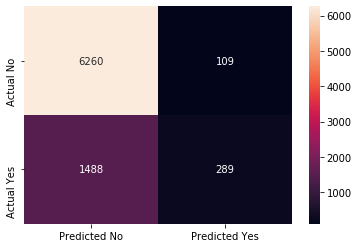

In [16]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 2. Naive Bayes

In [17]:
naive_clf = GaussianNB()

start = time.time()
naive_clf.fit(X_train,Y_train)
naive_trainTime = time.time() - start

naive_predValues = naive_clf.predict(X_test)
accuracy_naive,recall_naive,precision_naive,fscore_naive,confusion = scores(Y_test,naive_predValues)

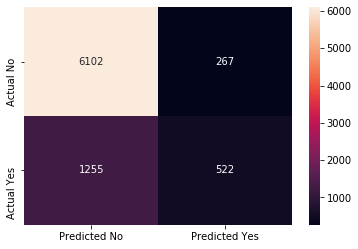

In [18]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 3. Support Vector Machine

In [19]:
svc = SVC()
start = time.time()
svc.fit(X_train,Y_train)
svc_trainTime = time.time() - start

tree_predValueS = svc.predict(X_test)
accuracy_svc,recall_svc,precision_svc,fscore_tree,confusion = scores(Y_test,tree_predValueS)

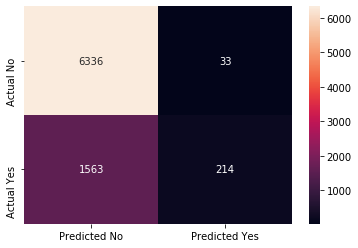

In [20]:
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 4. Decision Tree Classifier

In [21]:
tree_clf = DecisionTreeClassifier()

start = time.time()
tree_clf.fit(X_train,Y_train)
tree_trainTime = time.time() - start

tree_predValues = tree_clf.predict(X_test)
accuracy_tree,recall_tree,precision_tree,fscore_tree,confusion = scores(Y_test,tree_predValues)

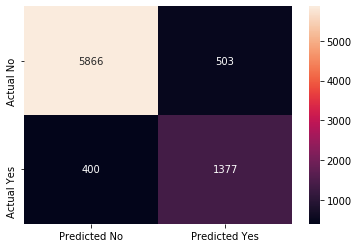

In [22]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

## Comparison of traditional approach

In [23]:
data_comparison=[[logistic_trainTime,accuracy_log,recall_log,precision_log,fscore_log],[naive_trainTime,accuracy_naive,recall_naive,precision_naive,fscore_naive],
                 [svc_trainTime,accuracy_svc,recall_svc,precision_svc,fscore_tree,],
     [tree_trainTime,accuracy_tree,recall_tree,precision_tree,fscore_tree]]

comparison_tabel1 = pd.DataFrame(data_comparison,index= ['Logistic-Regression','Naive Bayes','Support Vector','Decision-Tree'],columns=['Time','Accuracy','Recall','Precision','F1-Score'])

In [24]:
comparison_tabel1

,Time,Accuracy,Recall,Precision,F1-Score
Logistic-Regression,0.193910,0.803953,0.162634,0.726131,0.265747
Naive Bayes,0.015136,0.813160,0.293754,0.661597,0.406859
Support Vector,16.870619,0.804076,0.120428,0.866397,0.753076
Decision-Tree,0.169822,0.889148,0.774902,0.732447,0.753076


## Ensemble Learning Approach

#### 1. Random Forest Classifier

In [25]:
rnd_clf = RandomForestClassifier()

start = time.time()
rnd_clf.fit(X_train,Y_train)
forest_trainTime = time.time() - start

randomForest_predValues = rnd_clf.predict(X_test)
accuracy_rnd,recall_rnd,precision_rnd,fscore_rnd,confusion = scores(Y_test,randomForest_predValues)


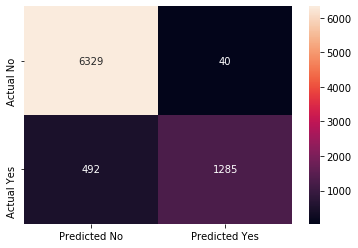

In [26]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

####  2. Ada Boost Classifier

In [27]:
ada_clf = AdaBoostClassifier()

start = time.time()
ada_clf.fit(X_train,Y_train)
ada_trainTime = time.time() - start

ada_predValues = ada_clf.predict(X_test)
accuracy_ada,recall_ada,precision_ada,fscore_ada,confusion = scores(Y_test,ada_predValues)


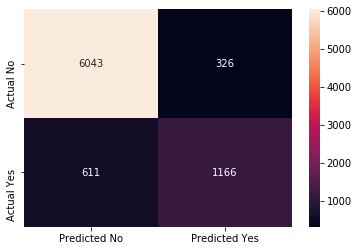

In [28]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 3. XGBoost Classifier

In [29]:
xgb_clf = XGBClassifier()

start = time.time()
xgb_clf.fit(X_train,Y_train)
xgb_trainTime = time.time() - start

xgb_predValues = xgb_clf.predict(X_test)
accuracy_xgb,recall_xgb,precision_xgb,fscore_xgb,confusion = scores(Y_test,xgb_predValues)


C:\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


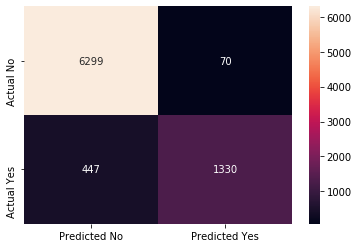

In [30]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 4. LightGBM Classifier

In [31]:
lgbm_clf = LGBMClassifier()

start = time.time()
lgbm_clf.fit(X_train,Y_train)
lgbm_trainTime = time.time() - start

lgbm_predValues = lgbm_clf.predict(X_test)
accuracy_lgbm,recall_lgbm,precision_lgbm,fscore_lgbm,confusion = scores(Y_test,lgbm_predValues)


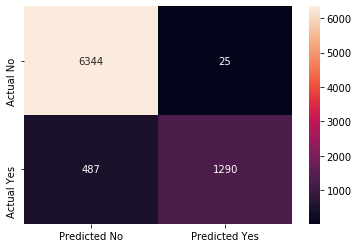

In [32]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

### Comparison of Ensemble Learning Approach

In [33]:
data_comparison = [[forest_trainTime,accuracy_rnd,recall_rnd,precision_rnd,fscore_rnd],
                  [ada_trainTime,accuracy_ada,recall_ada,precision_ada,fscore_ada],
                  [xgb_trainTime,accuracy_xgb,recall_xgb,precision_xgb,fscore_xgb],
                  [lgbm_trainTime,accuracy_lgbm,recall_lgbm,precision_lgbm,fscore_lgbm]]
comparison_tabel2 = pd.DataFrame(data_comparison,index= ['Random-Forest-Classifier','Ada-Boost-Classifier','XGBoost-Classifier','LightGBM-Classifier'],
                                 columns=['Time','Accuracy','Recall','Precision','F1-Score'])

In [34]:
comparison_tabel2

,Time,Accuracy,Recall,Precision,F1-Score
Random-Forest-Classifier,2.441980,0.934692,0.723129,0.969811,0.828498
Ada-Boost-Classifier,0.990757,0.884974,0.656162,0.781501,0.713368
XGBoost-Classifier,1.228557,0.936533,0.748452,0.950000,0.837268
LightGBM-Classifier,0.191202,0.937147,0.725943,0.980989,0.834411


### Comparison of all training methods

In [35]:
table_org = comparison_tabel1.append(comparison_tabel2)
table_org

,Time,Accuracy,Recall,Precision,F1-Score
Logistic-Regression,0.193910,0.803953,0.162634,0.726131,0.265747
Naive Bayes,0.015136,0.813160,0.293754,0.661597,0.406859
Support Vector,16.870619,0.804076,0.120428,0.866397,0.753076
Decision-Tree,0.169822,0.889148,0.774902,0.732447,0.753076
Random-Forest-Classifier,2.441980,0.934692,0.723129,0.969811,0.828498
Ada-Boost-Classifier,0.990757,0.884974,0.656162,0.781501,0.713368
XGBoost-Classifier,1.228557,0.936533,0.748452,0.950000,0.837268
LightGBM-Classifier,0.191202,0.937147,0.725943,0.980989,0.834411


### Prediction using the best model

In [36]:
### LightGBM classifier is the best model 
 
df = pd.DataFrame({'Actual': Y_test, 'Predicted': lgbm_predValues})
df

,Actual,Predicted
2300,1,0
23858,0,0
5777,0,0
4920,0,0
24466,0,0
...,...,...
30468,0,0
24318,0,0
9973,0,0
12208,0,0


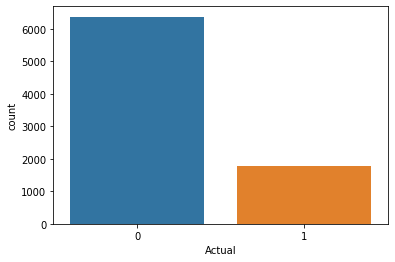

In [37]:
sns.countplot(x='Actual',data=df)

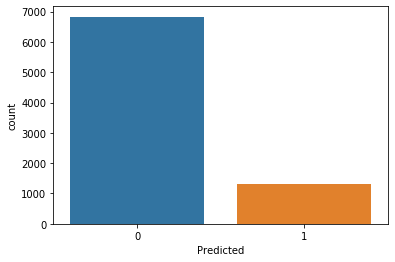

In [38]:
sns.countplot(x='Predicted',data=df)

# PCA Data

In [39]:
pca = PCA(n_components=6)
data_pca = pca.fit_transform(data)

### Splitting PCA Data

In [40]:
X_train_pca,X_test_pca,Y_train_pca,Y_test_pca = train_test_split(data_pca,labels,stratify=labels,random_state=42)

## Traditional Approach

#### 1. Logistic Regression

In [41]:
log_reg = LogisticRegression()

start = time.time()
log_reg.fit(X_train_pca,Y_train_pca)
logistic_trainTime = time.time() - start

logistic_predValues = log_reg.predict(X_test_pca)
accuracy_log,recall_log,precision_log,fscore_log,confusion = scores(Y_test_pca,logistic_predValues)

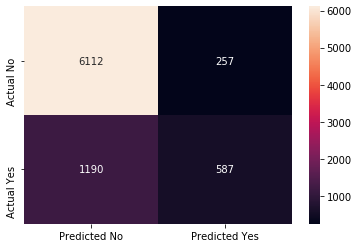

In [42]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 2. Naive Bayes

In [43]:
naive_clf = GaussianNB()

start = time.time()
naive_clf.fit(X_train_pca,Y_train_pca)
naive_trainTime = time.time() - start

naive_predValues = naive_clf.predict(X_test_pca)
accuracy_naive,recall_naive,precision_naive,fscore_naive,confusion = scores(Y_test_pca,naive_predValues)

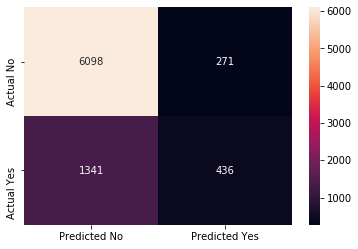

In [44]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 3. Support Vector Machine

In [45]:
Svc = SVC()

start = time.time()
Svc.fit(X_train_pca,Y_train_pca)
Svc_trainTime = time.time() - start

Svc_predValues = Svc.predict(X_test_pca)
accuracy_Svc,recall_Svc,precision_Svc,fscore_Svc,confusion = scores(Y_test_pca,Svc_predValues)

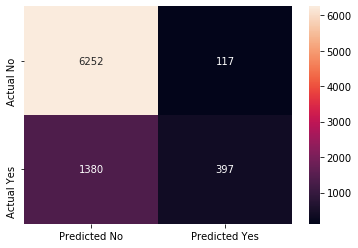

In [46]:
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 4. Decision Tree Classifier

In [47]:
tree_clf = DecisionTreeClassifier()

start = time.time()
tree_clf.fit(X_train_pca,Y_train_pca)
tree_trainTime = time.time() - start

tree_predValues = tree_clf.predict(X_test_pca)
accuracy_tree,recall_tree,precision_tree,fscore_tree,confusion = scores(Y_test_pca,tree_predValues)

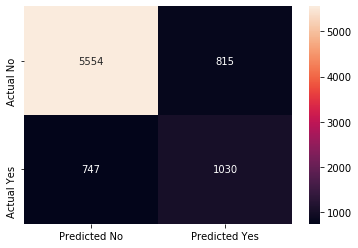

In [48]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

## Comparison of traditional approach

In [49]:
data_comparison=[[logistic_trainTime,accuracy_log,recall_log,precision_log,fscore_log],[naive_trainTime,accuracy_naive,recall_naive,precision_naive,fscore_naive],
                 [Svc_trainTime,accuracy_Svc,recall_Svc,precision_Svc,fscore_Svc],[tree_trainTime,accuracy_tree,recall_tree,precision_tree,fscore_tree]]

comparison_tabel_PCA1 = pd.DataFrame(data_comparison,index= ['Logistic-Regression','Naive Bayes','Support Vector','Decision-Tree'],columns=['Time','Accuracy','Recall','Precision','F1-Score'])

In [50]:
comparison_tabel_PCA1

,Time,Accuracy,Recall,Precision,F1-Score
Logistic-Regression,0.151895,0.822367,0.330332,0.695498,0.447921
Naive Bayes,0.009065,0.802111,0.245357,0.616690,0.351047
Support Vector,9.398021,0.816229,0.223410,0.772374,0.346574
Decision-Tree,0.244117,0.808249,0.579629,0.558266,0.568747


## Ensemble Learning Approach

#### 1. Random Forest Classifier

In [51]:
rnd_clf = RandomForestClassifier()

start = time.time()
rnd_clf.fit(X_train_pca,Y_train_pca)
forest_trainTime = time.time() - start

randomForest_predValues = rnd_clf.predict(X_test_pca)
accuracy_rnd,recall_rnd,precision_rnd,fscore_rnd,confusion = scores(Y_test_pca,randomForest_predValues)


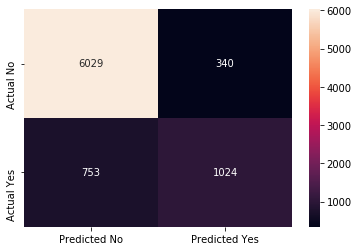

In [52]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 2. Ada Boost Classifier

In [53]:
ada_clf = AdaBoostClassifier()

start = time.time()
ada_clf.fit(X_train_pca,Y_train_pca)
ada_trainTime = time.time() - start

ada_predValues = ada_clf.predict(X_test_pca)
accuracy_ada,recall_ada,precision_ada,fscore_ada,confusion = scores(Y_test_pca,ada_predValues)


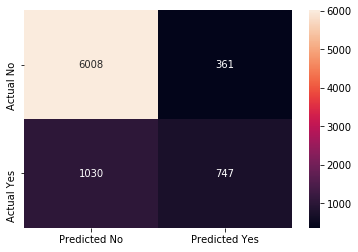

In [54]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 3. XGBoost Classifier

In [55]:
xgb_clf = XGBClassifier()

start = time.time()
xgb_clf.fit(X_train_pca,Y_train_pca)
xgb_trainTime = time.time() - start

xgb_predValues = xgb_clf.predict(X_test_pca)
accuracy_xgb,recall_xgb,precision_xgb,fscore_xgb,confusion = scores(Y_test_pca,xgb_predValues)


C:\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


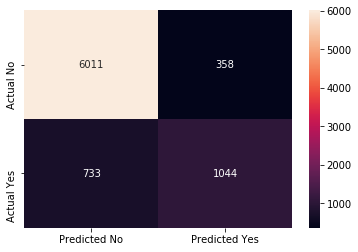

In [56]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

#### 4. LightGBM Classifier

In [57]:
lgbm_clf = LGBMClassifier()

start = time.time()
lgbm_clf.fit(X_train_pca,Y_train_pca)
lgbm_trainTime = time.time() - start

lgbm_predValues = lgbm_clf.predict(X_test_pca)
accuracy_lgbm,recall_lgbm,precision_lgbm,fscore_lgbm,confusion = scores(Y_test_pca,lgbm_predValues)


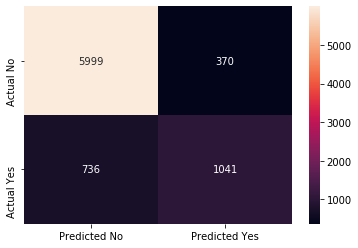

In [58]:
# Plotting Confusion Matrix
sns.heatmap(confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

### Comparison of Ensemble Learning Approach

In [59]:
data_comparison = [[forest_trainTime,accuracy_rnd,recall_rnd,precision_rnd,fscore_rnd],
                  [ada_trainTime,accuracy_ada,recall_ada,precision_ada,fscore_ada],
                 [xgb_trainTime,accuracy_xgb,recall_xgb,precision_xgb,fscore_xgb],
                   [lgbm_trainTime,accuracy_lgbm,recall_lgbm,precision_lgbm,fscore_lgbm],]
comparison_tabel_PCA2 = pd.DataFrame(data_comparison,index= ['Random-Forest-Classifier','Ada-Boost-Classifier','XGBoost-Classifier','LightGBM-Classifier'],
                                 columns=['Time','Accuracy','Recall','Precision','F1-Score'])
table = comparison_tabel_PCA1.append(comparison_tabel_PCA2)

In [60]:
comparison_tabel_PCA2

,Time,Accuracy,Recall,Precision,F1-Score
Random-Forest-Classifier,5.367084,0.865824,0.576252,0.750733,0.652022
Ada-Boost-Classifier,1.219690,0.829241,0.420371,0.674188,0.517851
XGBoost-Classifier,1.657057,0.866069,0.587507,0.744650,0.656810
LightGBM-Classifier,0.149707,0.864228,0.585819,0.737775,0.653074


In [61]:
table

,Time,Accuracy,Recall,Precision,F1-Score
Logistic-Regression,0.151895,0.822367,0.330332,0.695498,0.447921
Naive Bayes,0.009065,0.802111,0.245357,0.616690,0.351047
Support Vector,9.398021,0.816229,0.223410,0.772374,0.346574
Decision-Tree,0.244117,0.808249,0.579629,0.558266,0.568747
Random-Forest-Classifier,5.367084,0.865824,0.576252,0.750733,0.652022
Ada-Boost-Classifier,1.219690,0.829241,0.420371,0.674188,0.517851
XGBoost-Classifier,1.657057,0.866069,0.587507,0.744650,0.656810
LightGBM-Classifier,0.149707,0.864228,0.585819,0.737775,0.653074


# Comparison of Original data v/s Pca Data

In [62]:
cols = [["Original Data","Original Data","Original Data","Original Data","Original Data","Pca Data","Pca Data","Pca Data","Pca Data","Pca Data"],
       ['Time','Accuracy','Recall','Precision','F1-Score','Time','Accuracy','Recall','Precision','F1-Score']]
tuples = list(zip(*cols))
multi_column = pd.MultiIndex.from_tuples(tuples)


In [63]:
final_table = pd.DataFrame(index = table.index,columns=multi_column)

In [64]:
final_table["Original Data"] = table_org
final_table["Pca Data"] = table

In [65]:
final_table

Original Data                                \
                                  Time  Accuracy    Recall Precision   
Logistic-Regression           0.193910  0.803953  0.162634  0.726131   
Naive Bayes                   0.015136  0.813160  0.293754  0.661597   
Support Vector               16.870619  0.804076  0.120428  0.866397   
Decision-Tree                 0.169822  0.889148  0.774902  0.732447   
Random-Forest-Classifier      2.441980  0.934692  0.723129  0.969811   
Ada-Boost-Classifier          0.990757  0.884974  0.656162  0.781501   
XGBoost-Classifier            1.228557  0.936533  0.748452  0.950000   
LightGBM-Classifier           0.191202  0.937147  0.725943  0.980989   

                                    Pca Data                                \
                          F1-Score      Time  Accuracy    Recall Precision   
Logistic-Regression       0.265747  0.151895  0.822367  0.330332  0.695498   
Naive Bayes               0.406859  0.009065  0.802111  0.245357  0.616690   
Support Vector            0.753076  9.398021  0.816229  0.223410  0.772374   
Decision-Tree             0.753076  0.244117  0.808249  0.579629  0.558266   
Random-Forest-Classifier  0.828498  5.367084  0.865824  0.576252  0.750733   
Ada-Boost-Classifier      0.713368  1.219690  0.829241  0.420371  0.674188   
XGBoost-Classifier        0.837268  1.657057  0.866069  0.587507  0.744650   
LightGBM-Classifier       0.834411  0.149707  0.864228  0.585819  0.737775   

                                    
                          F1-Score  
Logistic-Regression       0.447921  
Naive Bayes               0.351047  
Support Vector            0.346574  
Decision-Tree             0.568747  
Random-Forest-Classifier  0.652022  
Ada-Boost-Classifier      0.517851  
XGBoost-Classifier        0.656810  
LightGBM-Classifier       0.653074

In [66]:
def plot(values_org,values_pca,index,cName):
    plt.title(cName)
    plt.plot(index,values_org,"*--r",label="Org Data")
    plt.plot(index,values_pca,"*-b",label="Pca Data")
    plt.legend()
    plt.xticks(rotation=70)
    plt.show()

In [67]:
final_table["Original Data"]["Time"]

Logistic-Regression          0.193910
Naive Bayes                  0.015136
Support Vector              16.870619
Decision-Tree                0.169822
Random-Forest-Classifier     2.441980
Ada-Boost-Classifier         0.990757
XGBoost-Classifier           1.228557
LightGBM-Classifier          0.191202
Name: Time, dtype: float64

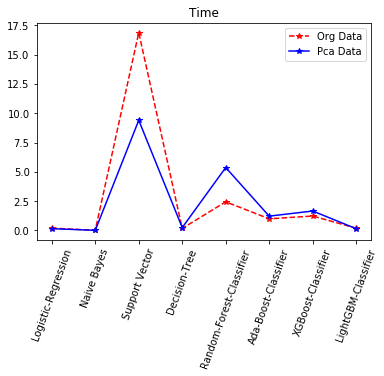

In [68]:
plot(final_table["Original Data"]["Time"],final_table["Pca Data"]["Time"],final_table.index,"Time")

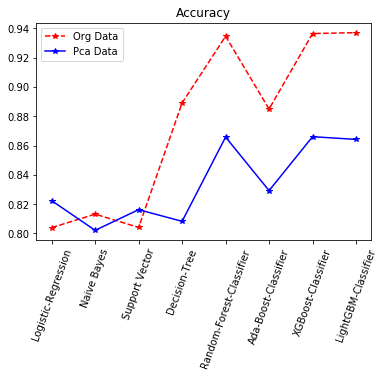

In [69]:
plot(final_table["Original Data"]["Accuracy"],final_table["Pca Data"]["Accuracy"],final_table.index,"Accuracy")

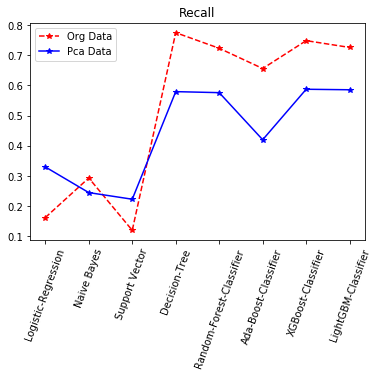

In [70]:
plot(final_table["Original Data"]["Recall"],final_table["Pca Data"]["Recall"],final_table.index,"Recall")

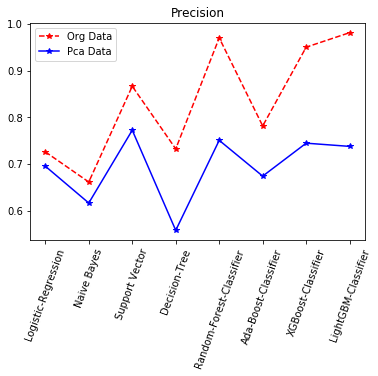

In [71]:
plot(final_table["Original Data"]["Precision"],final_table["Pca Data"]["Precision"],final_table.index,"Precision")

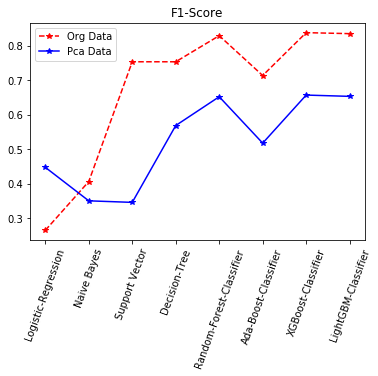

In [72]:
plot(final_table["Original Data"]["F1-Score"],final_table["Pca Data"]["F1-Score"],final_table.index,"F1-Score")

### Thank You